# k-means clustering
k-means clustering is an unsupervised machine learning model. It clusters observations into k partitions.

## The algorithm

The algorithm has two steps and an initialization procedure.

### Initialization

Generate k random points in the sample space or choose k random observations as the inital centroids.

### Assignment

Assign each observation to the nearest centroid.

### Update

Move each centroid to the mean of the observations assigned to it.

### Convergence

The algorithm converges when no new assignments are made in an iteration.

In [81]:
import numpy as np

def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    """Euclidean distance between two vectors.
    
    Args:
        a: First vector.
        b: Second vector.
    
    Returns:
        Euclidean distance between a and b.
    """
    return np.sqrt(np.sum(np.square(a - b)))

def k_means(k: int, data: np.ndarray) ->tuple[np.ndarray, np.ndarray]:
    """K-means clustering algorithm.
    
    Args:
        k: Number of clusters.
        data: Data to cluster.
    
    Returns:
        Cluster assignments for each data point and cluster centroids.
    """
    # Initialize centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
    
    # Initialize assignments
    assignments = np.zeros(data.shape[0])
    
    # Iterate until convergence
    while True:
        # Assign data points to centroids
        for i in range(data.shape[0]):
            distances = np.zeros(k)
            for j in range(k):
                distances[j] = euclidean_distance(data[i, :], centroids[j, :])
            assignments[i] = np.argmin(distances)
        
        # Update centroids
        new_centroids = np.zeros((k, data.shape[1]))
        for j in range(k):
            new_centroids[j, :] = np.mean(data[assignments == j, :], axis=0)
        
        # Check convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return assignments, centroids

## Testing

The distortion is a method of determining the quality of fit. It measures the sum of the squared distances between observations and their centroids. By it's nature the k-means algorithm monotonically decreases the distortion values of it's assignments each iteration until convergence.

In [82]:
def distortion(data: np.ndarray, assignments: np.ndarray, centroids: np.ndarray) -> float:
    """Compute distortion.
    
    Args:
        data: Data to cluster.
        assignments: Cluster assignments.
        centroids: Cluster centroids.
    
    Returns:
        Distortion.
    """
    distortion = 0
    for i in range(data.shape[0]):
        distortion += euclidean_distance(data[i, :], centroids[int(assignments[i]), :])
    return distortion

In [83]:
def generate_data(n: int, d: int, k: int, var: float) -> np.ndarray:
    """Generate data in k clusters as a normal distribution centered around a random point.
    
    Args:
        n: Number of data points per cluster.
        d: Number of dimensions.
        k: Number of clusters.
        var: Variance of the normal distribution.
    
    Returns:
        Data.
    """
    data = np.zeros((n * k, d))
    for i in range(k):
        mu = np.random.uniform(-1, 1, d) * 10
        data[i * n:(i + 1) * n, :] = np.random.normal(mu, var, (n, d))
    return data

## Visualizing the results

### Non-optimality

In some runs the algorithm can converge on clearly un-optimal clusters. This is because, even though the distortion is monotonically decreasing, the algorithm can become stuck in local optimums.

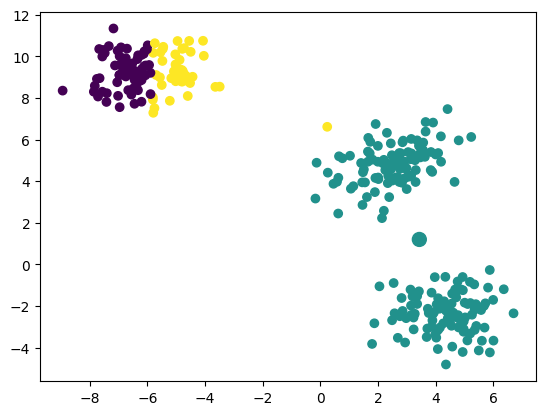

In [110]:
from matplotlib import pyplot as plt

def plot_data(data: np.ndarray, assignments: np.ndarray, centroids: np.ndarray) -> None:
    """Plot data.
    
    Args:
        data: Data to plot.
        assignments: Cluster assignments.
        centroids: Cluster centroids.

    Raises:
        ValueError: If data is not 2D or 3D.
    """
    # Plot 2D data
    if data.shape[1] == 2:
        plt.scatter(data[:, 0], data[:, 1], c=assignments)
        plt.scatter(centroids[:, 0], centroids[:, 1], c=range(len(centroids)), s=100)
        plt.show()
    # Plot 3D data
    elif data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=assignments)
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c=range(len(centroids)), s=100)
        plt.show()
    else:
        raise ValueError('Data must be 2D or 3D.')

# Generate data
data = generate_data(100, 2, 3, 1)

# Cluster data
assignments, centroids = k_means(3, data)

# Plot data
plot_data(data, assignments, centroids)


## Improvements

Various techniques can produce better fits.

### Best of multiple trials

Starting with roughtly correct inital centroids will mean the algorithm conveges to a globally optimal result. If several trials are run and the best is picked, it's much less likely that the optimal result is missed.

Run this trial a few times and try to find an unoptimal result.

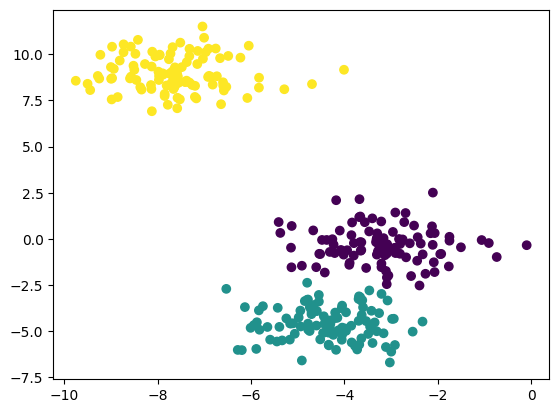

In [92]:
def best_of_n(k: int, data: np.ndarray, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Run k-means n times and return the best result.
    
    Args:
        k: Number of clusters.
        data: Data to cluster.
        n: Number of times to run k-means.
    
    Returns:
        Cluster assignments and cluster centroids.
    """
    best_assignments = None
    best_centroids = None
    best_distortion = np.inf
    for i in range(n):
        assignments, centroids = k_means(k, data)
        d = distortion(data, assignments, centroids)
        if d < best_distortion:
            best_assignments = assignments
            best_centroids = centroids
            best_distortion = d
    return best_assignments, best_centroids

# Run k-means 10 times and plot the best result
assignments, centroids = best_of_n(3, data, 10)

# Plot data
plot_data(data, assignments, centroids)

### k estimation

For some data the number of clusters is unknown and must be estimated. If k is too low distortion values will usually be quite high. If k is too high the model can begin to overfit. The elbow method of finding k is two take the distortion in a range and chose the k at the inflection point. This is usually where the number of clusters is correct and adding more grants diminishing returns.

As you can see in this there is a significant inflection point at the correct number of clusters.

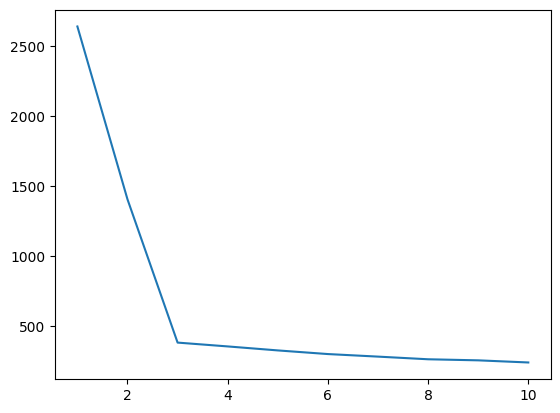

In [86]:
# Generate data
data = generate_data(100, 2, 3, 1)

# Plot distortion vs. k
max_k = 10
distortions = []
for k in range(1, max_k + 1):
    assignments, centroids = best_of_n(k, data, 10)
    distortions.append(distortion(data, assignments, centroids))
plt.plot(range(1, max_k + 1), distortions)
plt.show()

k = 1


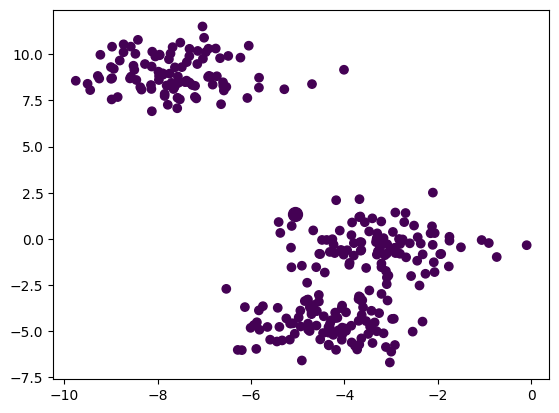

In [89]:
def estimate_k(data: np.ndarray, max_k: int) -> int:
    """Estimate the number of clusters in data using the elbow method.
    
    Args:
        data: Data to cluster.
        max_k: Maximum number of clusters to try.
    
    Returns:
        Estimated number of clusters.
    """
    distortions = []
    for k in range(1, max_k + 1):
        assignments, centroids = best_of_n(k, data, 5)
        distortions.append(distortion(data, assignments, centroids))
    return np.argmin(np.diff(distortions)) + 1

# Generate data
data = generate_data(100, 2, 3, 1)

# Estimate k
k = estimate_k(data, 10)
print(f"k = {k}")

# Cluster data
assignments, centroids = best_of_n(k, data, 10)

# Plot data
plot_data(data, assignments, centroids)